- what are the nearest neighbors of the additional graph structure induced by the adversary?

- Computing something like an "average" subgraph for a class might be difficult because it is unclear how we deal with conflicting directions on edge weights and how we actually average over all the possible subgraphs examples from various classes could elicit
    - But this analysis would be fairly interesting. Should think more about how to do this

In [1]:
import os
import parse

import torch
import torch.nn.functional as F
from torchvision import datasets, transforms
import dionysus as dion
import numpy as np
from scipy.spatial.distance import hamming, cosine
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx

PERCENTILE = 0

from pt_activation.models.ccff import CCFF

%load_ext autoreload
%autoreload 2

In [2]:
def get_adv_info(filename):
    format_string = 'true-{}_adv-{}_sample-{}.npy'
    parsed = parse.parse(format_string, filename)
    return {'true class':int(parsed[0]), 'adv class':int(parsed[1]), 'sample':int(parsed[2])}

def read_adversaries(loc):
    ret = []
    for f in os.listdir(loc):
        if os.path.isfile(os.path.join(loc,f)) and f.find('.npy') != -1:
            adv = np.load(os.path.join(loc, f))
            info = get_adv_info(f)
            info['adversary'] = adv
            ret.append(info)
    return ret
    

In [3]:
adv_directory_loc = '/home/tgebhart/projects/pt_activation/logdir/adversaries/mnist/projected_gradient_descent/ccff_relu.pt'
adversaries = read_adversaries(adv_directory_loc)
adversaries = sorted(adversaries,  key=lambda k: k['sample'])

In [4]:
def get_adv_dists(adversaries, up_to):
    device = torch.device('cpu')
    dists = np.zeros(up_to)
    i = 0
    ims = []
    kwargs = {'num_workers': 0, 'pin_memory': False}
    test_loader = torch.utils.data.DataLoader(
        datasets.MNIST('../data', train=False, download=True, transform=transforms.Compose([
                           transforms.ToTensor(),
#                            transforms.Normalize((0.1307,), (0.3081,))
                       ])), batch_size=1, shuffle=False, **kwargs)
    adv_images = np.array([a['adversary'] for a in adversaries])
    with torch.no_grad():
        for data, target in test_loader:
            d = data.numpy()[0].reshape(28*28)
            ims.append(d)
            dists[i] = np.linalg.norm(d-adv_images[i].reshape(28*28),2)
            i += 1
            if i >= up_to:
                break
            
    return dists, ims, adv_images

def create_sample_graph(f,tnms,wm):

    subgraphs = {}
    m = dion.homology_persistence(f)
    dgm = dion.init_diagrams(m,f)[0]
    for i,c in enumerate(m):
        if len(c) == 2:
            w = f[i].data
            if (tnms[f[c[0].index][0]],tnms[f[c[1].index][0]]) in wm:
                w = wm[(tnms[f[c[0].index][0]],tnms[f[c[1].index][0]])]
            elif (tnms[f[c[1].index][0]],tnms[f[c[0].index][0]]) in wm:
                w = wm[(tnms[f[c[1].index][0]],tnms[f[c[0].index][0]])]
#                 else:
#                     print((tnms[f[c[0].index][0]],tnms[f[c[1].index][0]]))
#                     raise Exception('NO WM!')
            if False: #tnms[f[c[0].index][0]] in subgraphs:
                subgraphs[tnms[f[c[0].index][0]]].add_edge(tnms[f[c[0].index][0]],tnms[f[c[1].index][0]], weight=w)
            else:
                eaten = False
                for k, v in subgraphs.items():
                    if v.has_node(tnms[f[c[0].index][0]]):
                        if tnms[f[c[1].index][0]] in subgraphs:
                            v.add_node(tnms[f[c[1].index][0]])
#                                 subgraphs[k] = nx.union(v, subgraphs[tnms[f[c[1].index][0]]])
                        else:
                            v.add_edge(tnms[f[c[0].index][0]], tnms[f[c[1].index][0]], weight=w)
                        eaten = True
                        break
                if not eaten:
                    g = nx.Graph()
                    g.add_edge(tnms[f[c[0].index][0]], tnms[f[c[1].index][0]], weight=w)
                    subgraphs[tnms[f[c[0].index][0]]] = g

    return subgraphs, dgm, create_lifetimes(f,subgraphs,dgm,tnms)

def create_lifetimes(f, subgraphs, dgm, ids):
    lifetimes = {}
    for pt in dgm:
        k = ids[f[pt.data][0]]
        if k in subgraphs.keys():
            if pt.death < float('inf'):
                lifetimes[k] = pt.birth - pt.death
            else:
                lifetimes[k] = pt.birth
    return lifetimes



# In[9]:


def create_subgraphs(model, batch_size, up_to):
    device = torch.device("cpu")
    kwargs = {'num_workers': 0, 'pin_memory': False}
    test_loader = torch.utils.data.DataLoader(
        datasets.MNIST('../data', train=False, download=True, transform=transforms.Compose([
                           transforms.ToTensor(),
#                            transforms.Normalize((0.1307,), (0.3081,))
                       ])), batch_size=batch_size, shuffle=False, **kwargs)

    model.eval()
    test_loss = 0
    correct = 0
    t = 0
    res_df = []
    subgraphs = []
    diagrams = []
    lifetimes = []
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output, hiddens = model(data, hiddens=True)
            test_loss = F.nll_loss(output, target).item() # sum up batch loss
            pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

            for s in range(data.shape[0]):
                this_hiddens = [hiddens[i][s] for i in range(len(hiddens))]
                print('Filtration: {}'.format(s+t))
                f, nm, wm = model.compute_dynamic_filtration2(data[s], this_hiddens, percentile=PERCENTILE, return_nm=True, absolute_value=True)
                tnm = {v: k for k, v in nm.items()}
                sg, dg, lifetime = create_sample_graph(f, tnm, wm)
                row = {'loss':test_loss, 'class':target.cpu().numpy()[s], 'prediction':pred.cpu().numpy()[s][0]}
                res_df.append(row)
                subgraphs.append(sg)
                diagrams.append(dg)
                lifetimes.append(lifetime)

            t += batch_size
            if t >= up_to:
                break

    return pd.DataFrame(res_df), subgraphs, diagrams, lifetimes


def create_adversary_subgraphs(model, batch_size, up_to, adversaries):
    device = torch.device("cpu")
    adv_images = torch.tensor(np.array([a['adversary'] for a in adversaries]))
    adv_labels = torch.tensor(np.array([a['true class'] for a in adversaries]))
    adv_samples = [a['sample'] for a in adversaries]

    print(adv_images.shape, adv_labels.shape)

    advs = torch.utils.data.TensorDataset(adv_images, adv_labels)
    test_loader = torch.utils.data.DataLoader(advs, batch_size=batch_size, shuffle=False)

    model.eval()
    test_loss = 0
    correct = 0
    t = 0
    res_df = []
    subgraphs = []
    diagrams = []
    lifetimes = []
    with torch.no_grad():

        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output, hiddens = model(data, hiddens=True)
            test_loss = F.nll_loss(output, target).item() # sum up batch loss
            pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()
            for s in range(data.shape[0]):
                this_hiddens = [hiddens[i][s] for i in range(len(hiddens))]
                print('Filtration: {}'.format(s+t))
                f, nm, wm = model.compute_dynamic_filtration2(data[s], this_hiddens, percentile=PERCENTILE, return_nm=True, absolute_value=True)
                tnm = {v: k for k, v in nm.items()}
                sg, dg, lifetime = create_sample_graph(f, tnm, wm)
                row = {'loss':test_loss, 'class':target.cpu().numpy()[s], 'prediction':pred.cpu().numpy()[s][0]}
                res_df.append(row)
                subgraphs.append(sg)
                diagrams.append(dg)
                lifetimes.append(lifetime)

            t += (batch_size)
            if t >= up_to:
                break

    return pd.DataFrame(res_df), subgraphs, diagrams, lifetimes

def create_moved_subgraphs(model, ims, labels, devs, batch_size, up_to, times=1):
    device = torch.device("cpu")

    nims = []
    for i in range(len(ims)):
#         print('finding alteration number', i)
        im = ims[i]
        dev = devs[i]
        delim = np.zeros(im.shape, dtype=im.dtype)
        sigma = 0
        while np.linalg.norm(im+delim - im) < dev:
            sigma += 0.00001
            delim = np.random.normal(scale=sigma, size=im.shape)
        nims.append((im+delim).reshape(1,28,28))
    tims = torch.FloatTensor(nims)
    tlabels = torch.tensor(labels)
    print(tims.shape, tlabels.shape, type(tims), type(tlabels))
    dataset = torch.utils.data.TensorDataset(tims, tlabels)
    test_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=False)
    
    model.eval()
    test_loss = 0
    correct = 0
    t = 0
    res_df = []
    subgraphs = []
    diagrams = []
    lifetimes = []
    with torch.no_grad():

        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output, hiddens = model(data, hiddens=True)
            test_loss = F.nll_loss(output, target).item() # sum up batch loss
            pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()
            for s in range(data.shape[0]):
                this_hiddens = [hiddens[i][s] for i in range(len(hiddens))]
                print('Filtration: {}'.format(s+t))
                f, nm, wm = model.compute_dynamic_filtration2(data[s], this_hiddens, percentile=PERCENTILE, return_nm=True, absolute_value=True)
                tnm = {v: k for k, v in nm.items()}
                sg, dg, lifetime = create_sample_graph(f, tnm, wm)
                row = {'loss':test_loss, 'class':target.cpu().numpy()[s], 'prediction':pred.cpu().numpy()[s][0]}
                res_df.append(row)
                subgraphs.append(sg)
                diagrams.append(dg)
                lifetimes.append(lifetime)

            t += (batch_size)
            if t >= up_to:
                break

    return pd.DataFrame(res_df), subgraphs, diagrams, lifetimes, nims

In [5]:
model_location = '/home/tgebhart/projects/pt_activation/logdir/models/mnist/ccff_relu.pt'
model = CCFF()
model.load_state_dict(torch.load(model_location))

In [6]:
res_df, sample_graphs, diagrams, lifetimes = create_subgraphs(model, 50, 100)

Filtration: 0
filtration size 167725
Filtration: 1
filtration size 203686
Filtration: 2
filtration size 118369
Filtration: 3
filtration size 225592
Filtration: 4
filtration size 212016
Filtration: 5
filtration size 129519
Filtration: 6
filtration size 199982
Filtration: 7
filtration size 179304
Filtration: 8
filtration size 210750
Filtration: 9
filtration size 195287
Filtration: 10
filtration size 232192
Filtration: 11
filtration size 228582
Filtration: 12
filtration size 178645
Filtration: 13
filtration size 228896
Filtration: 14
filtration size 132315
Filtration: 15
filtration size 223975
Filtration: 16
filtration size 205152
Filtration: 17
filtration size 173056
Filtration: 18
filtration size 232737
Filtration: 19
filtration size 183604
Filtration: 20
filtration size 183907
Filtration: 21
filtration size 189685
Filtration: 22
filtration size 220391
Filtration: 23
filtration size 189964
Filtration: 24
filtration size 196951
Filtration: 25
filtration size 256030
Filtration: 26
filtrat

In [7]:
adv_df, adv_sample_graphs, adv_diagrams, adv_lifetimes = create_adversary_subgraphs(model, 50, 100, adversaries)

torch.Size([4000, 1, 28, 28]) torch.Size([4000])
Filtration: 0
filtration size 308528
Filtration: 1
filtration size 307895
Filtration: 2
filtration size 306632
Filtration: 3
filtration size 320497
Filtration: 4
filtration size 295315
Filtration: 5
filtration size 302401
Filtration: 6
filtration size 298970
Filtration: 7
filtration size 323140
Filtration: 8
filtration size 292159
Filtration: 9
filtration size 316468
Filtration: 10
filtration size 321882
Filtration: 11
filtration size 306903
Filtration: 12
filtration size 317950
Filtration: 13
filtration size 313028
Filtration: 14
filtration size 321510
Filtration: 15
filtration size 300119
Filtration: 16
filtration size 307886
Filtration: 17
filtration size 312323
Filtration: 18
filtration size 299690
Filtration: 19
filtration size 316189
Filtration: 20
filtration size 299761
Filtration: 21
filtration size 302749
Filtration: 22
filtration size 319853
Filtration: 23
filtration size 303903
Filtration: 24
filtration size 303840
Filtration:

In [8]:
dists, ims, adv_ims = get_adv_dists(adversaries, 100)

In [9]:
moved_df, moved_sample_graphs, moved_diagrams, moved_lifetimes, moved_ims = create_moved_subgraphs(model, ims, res_df['class'], dists, 100, 100, times=1)

torch.Size([100, 1, 28, 28]) torch.Size([100]) <class 'torch.Tensor'> <class 'torch.Tensor'>
Filtration: 0
filtration size 282092
Filtration: 1
filtration size 289296
Filtration: 2
filtration size 288246
Filtration: 3
filtration size 291569
Filtration: 4
filtration size 287441
Filtration: 5
filtration size 286229
Filtration: 6
filtration size 277262
Filtration: 7
filtration size 294188
Filtration: 8
filtration size 274669
Filtration: 9
filtration size 276350
Filtration: 10
filtration size 280198
Filtration: 11
filtration size 285286
Filtration: 12
filtration size 281040
Filtration: 13
filtration size 280526
Filtration: 14
filtration size 295499
Filtration: 15
filtration size 274292
Filtration: 16
filtration size 270614
Filtration: 17
filtration size 265023
Filtration: 18
filtration size 280930
Filtration: 19
filtration size 297993
Filtration: 20
filtration size 274568
Filtration: 21
filtration size 282714
Filtration: 22
filtration size 299721
Filtration: 23
filtration size 278386
Filtr

In [10]:
print('Moved Accuracy:', moved_df[moved_df['prediction'] == moved_df['class']].shape[0]/moved_df.shape[0])
print('Actual Accuracy:', res_df[res_df['prediction'] == res_df['class']].shape[0]/res_df.shape[0])
print('Adversary Accuracy:', adv_df[adv_df['prediction'] == adv_df['class']].shape[0]/adv_df.shape[0])

Moved Accuracy: 1.0
Actual Accuracy: 1.0
Adversary Accuracy: 0.0


In [11]:
res_df.head()

,class,loss,prediction
0,7,0.000094,7
1,2,0.000094,2
2,1,0.000094,1
3,0,0.000094,0
4,4,0.000094,4


In [12]:
goi = 1

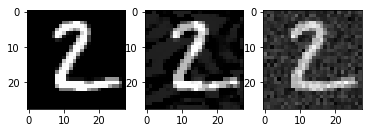

In [13]:
plt.subplot(131).imshow(ims[goi].reshape(28,28), cmap='gray')
plt.subplot(132).imshow(adv_ims[goi].reshape(28,28), cmap='gray')
plt.subplot(133).imshow(moved_ims[goi].reshape(28,28), cmap='gray')

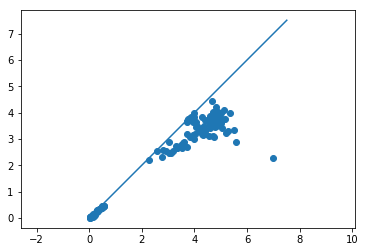

In [14]:
dion.plot.plot_diagram(diagrams[goi])

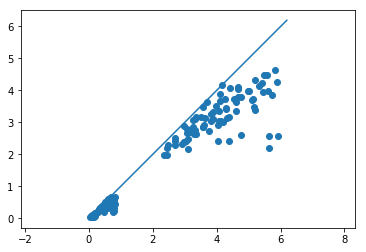

In [15]:
dion.plot.plot_diagram(adv_diagrams[goi])

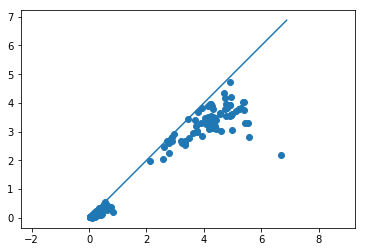

In [16]:
dion.plot.plot_diagram(moved_diagrams[goi])

In [17]:
lifetimes[goi]

{(3, 0, 9): 7.51272439956665,
 (3, 0, 7): 4.693403959274292,
 (1, 1, 440): 2.666851043701172,
 (1, 1, 469): 2.148007869720459,
 (1, 1, 470): 1.38507080078125,
 (1, 1, 182): 1.9916887283325195,
 (1, 1, 60): 1.97369384765625,
 (1, 1, 468): 1.4222826957702637,
 (1, 1, 158): 1.0301828384399414,
 (1, 1, 322): 1.654862642288208,
 (1, 1, 61): 1.2613987922668457,
 (1, 1, 416): 1.007176160812378,
 (1, 1, 229): 1.3737170696258545,
 (1, 1, 205): 0.994657039642334,
 (1, 1, 346): 0.8648867607116699,
 (1, 1, 465): 1.1205761432647705,
 (3, 0, 180): 0.9663848876953125,
 (1, 1, 467): 1.3316335678100586,
 (1, 1, 59): 1.3272812366485596,
 (1, 1, 206): 0.587806224822998,
 (1, 1, 299): 1.1503996849060059,
 (1, 1, 275): 0.9652090072631836,
 (1, 1, 369): 1.3141810894012451,
 (1, 1, 454): 1.6669368743896484,
 (1, 1, 441): 0.6913723945617676,
 (1, 1, 104): 1.5660138130187988,
 (1, 1, 252): 1.2003154754638672,
 (1, 1, 464): 0.22111988067626953,
 (1, 1, 345): 0.9382607936859131,
 (1, 1, 466): 1.0587844848632812,

In [18]:
adv_lifetimes[goi]

{(1, 1, 469): 6.195618629455566,
 (1, 1, 229): 3.3396615982055664,
 (1, 1, 468): 1.6180109977722168,
 (1, 1, 205): 1.171694278717041,
 (1, 1, 465): 1.8658692836761475,
 (3, 0, 9): 3.0597984790802,
 (3, 0, 7): 3.422616720199585,
 (1, 1, 440): 1.62349271774292,
 (1, 1, 470): 1.0940814018249512,
 (1, 1, 464): 1.0115180015563965,
 (1, 1, 467): 1.502697229385376,
 (1, 1, 182): 1.197160243988037,
 (1, 1, 466): 1.1709904670715332,
 (1, 1, 61): 1.813795804977417,
 (1, 1, 206): 0.8834309577941895,
 (3, 0, 180): 1.679302453994751,
 (1, 1, 86): 1.4026463031768799,
 (1, 1, 252): 1.4058780670166016,
 (1, 1, 158): 1.0069057941436768,
 (1, 1, 228): 1.000636339187622,
 (1, 1, 474): 2.1523473262786865,
 (1, 1, 181): 0.9597320556640625,
 (1, 1, 441): 0.6225829124450684,
 (1, 1, 110): 0.5822834968566895,
 (1, 1, 62): 0.8873879909515381,
 (1, 1, 60): 1.2685186862945557,
 (1, 1, 111): 0.9685614109039307,
 (1, 1, 87): 0.8270478248596191,
 (1, 1, 276): 0.3283824920654297,
 (1, 1, 104): 1.9866280555725098,
 (

In [19]:
moved_lifetimes[goi]

{(3, 0, 9): 6.878529071807861,
 (3, 0, 7): 4.488895893096924,
 (1, 1, 60): 2.752220869064331,
 (1, 1, 469): 2.2420668601989746,
 (1, 1, 182): 2.1228981018066406,
 (1, 1, 229): 1.6396126747131348,
 (1, 1, 470): 1.3871488571166992,
 (1, 1, 61): 1.3177318572998047,
 (1, 1, 252): 1.4524219036102295,
 (1, 1, 468): 1.4374995231628418,
 (1, 1, 275): 1.4348771572113037,
 (1, 1, 59): 1.406031847000122,
 (1, 1, 467): 1.3656651973724365,
 (1, 1, 454): 1.8924126625061035,
 (1, 1, 440): 1.3709421157836914,
 (1, 1, 466): 1.362478256225586,
 (1, 1, 465): 1.3518006801605225,
 (1, 1, 322): 1.3590998649597168,
 (1, 1, 276): 0.720454216003418,
 (3, 0, 21): 0.19739961624145508,
 (1, 1, 205): 0.9883468151092529,
 (1, 1, 471): 0.9823589324951172,
 (1, 1, 369): 1.3461153507232666,
 (1, 1, 158): 0.9645328521728516,
 (1, 1, 346): 0.8394629955291748,
 (3, 0, 180): 1.2067785263061523,
 (1, 1, 441): 0.9537124633789062,
 (1, 1, 299): 0.5698003768920898,
 (1, 1, 206): 0.3784303665161133,
 (1, 1, 104): 1.58186435699

In [20]:
sgk = (3,0,9)
agk = (3,0,9)
mgk = sgk

/home/tgebhart/.local/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


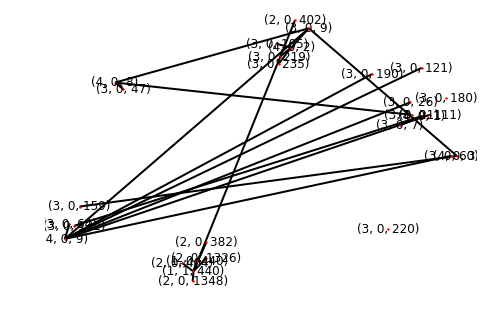

In [21]:
options = {
    'node_color': 'red',
    'node_size': 2,
    'width': 2,
    'with_labels':True}
nx.draw_spring(sample_graphs[goi][sgk], **options)

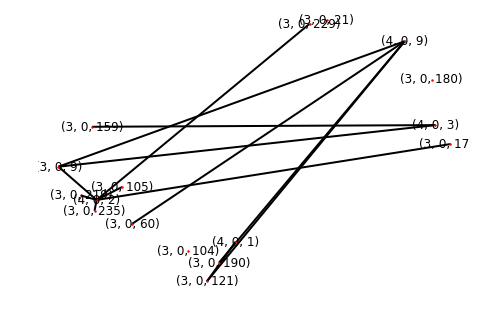

In [22]:
options = {
    'node_color': 'red',
    'node_size': 2,
    'width': 2,
    'with_labels':True}
nx.draw_spring(adv_sample_graphs[goi][agk], **options)

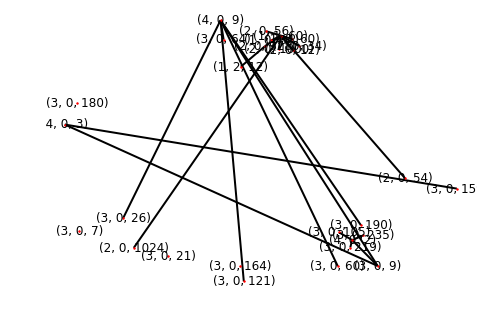

In [23]:
options = {
    'node_color': 'red',
    'node_size': 2,
    'width': 2,
    'with_labels':True}
nx.draw_spring(moved_sample_graphs[goi][mgk], **options)

In [34]:
def hamming_distance(g1, g2, ret_labels=False):
    nodeset = set(list(g1.nodes) + list(g2.nodes))
    g1_vec = np.zeros((len(nodeset)))
    g2_vec = np.zeros((len(nodeset)))
    nodesetlist = list(nodeset)
    for i in range(len(nodesetlist)):
        node = nodesetlist[i]
        if node in g1.nodes:
            g1_vec[i] = 1.0
        if node in g2.nodes:
            g2_vec[i] = 1.0
    if ret_labels:
        return hamming(g1_vec, g2_vec), nodesetlist
    else:
        return hamming(g1_vec, g2_vec)
    
def edge_hamming_distance(g1, g2, ret_labels=False):
    edgeset = set(list(g1.edges) + list(g2.edges))
    g1_vec = np.zeros((len(edgeset)))
    g2_vec = np.zeros((len(edgeset)))
    edgesetlist = list(edgeset)
    for i in range(len(edgesetlist)):
        edge = edgesetlist[i]
        if edge in g1.edges:
            g1_vec[i] = 1.0
        if edge in g2.edges:
            g2_vec[i] = 1.0
    if ret_labels:
        return hamming(g1_vec, g2_vec), edgesetlist
    else:
        return hamming(g1_vec, g2_vec)
    
def lifetime_weighted_edge_distance(subgraphs1,subgraphs2,lifetimes1,lifetimes2,ret_labels=False):
    edges1 = {}
    edges2 = {}
    sg1keys = list(subgraphs1.keys())
    sg2keys = list(subgraphs2.keys())
    lifetimes1 = list(lifetimes1.values())
    lifetimes2 = list(lifetimes2.values())
    ml1 = max(lifetimes1)
    ml2 = max(lifetimes2)
    for i in range(len(sg1keys)):
        g = subgraphs1[sg1keys[i]]
        for e in g.edges:
            edges1[e] = lifetimes1[i]/ml1
    for i in range(len(sg2keys)):
        g = subgraphs2[sg2keys[i]]
        for e in g.edges:
            edges2[e] = lifetimes2[i]/ml2
    edgeset = set(list(edges1.keys()) + list(edges2.keys()))
    g1_vec = np.zeros((len(edgeset)))
    g2_vec = np.zeros((len(edgeset)))
    edgesetlist = list(edgeset)
    for i in range(len(edgesetlist)):
        edge = edgesetlist[i]
        if edge in edges1:
            g1_vec[i] += edges1[edge]
        if edge in edges2:
            g2_vec[i] += edges2[edge]
    if ret_labels:
        return cosine(g1_vec, g2_vec), edgesetlist
    else:
        return cosine(g1_vec, g2_vec)
    
def full_weighted_edge_distance(subgraphs1, subgraphs2):
    edges1 = {}
    edges2 = {}
    sg1keys = list(subgraphs1.keys())
    sg2keys = list(subgraphs2.keys())
    lifetimes1 = np.ones(len(subgraphs1))
    lifetimes2 = np.ones(len(subgraphs2))
    ml1 = max(lifetimes1)
    ml2 = max(lifetimes2)
    for i in range(len(sg1keys)):
        g = subgraphs1[sg1keys[i]]
        for e in g.edges:
            edges1[e] = lifetimes1[i]/ml1
    for i in range(len(sg2keys)):
        g = subgraphs2[sg2keys[i]]
        for e in g.edges:
            edges2[e] = lifetimes2[i]/ml2
    edgeset = set(list(edges1.keys()) + list(edges2.keys()))
    g1_vec = np.zeros((len(edgeset)))
    g2_vec = np.zeros((len(edgeset)))
    edgesetlist = list(edgeset)
    for i in range(len(edgesetlist)):
        edge = edgesetlist[i]
        if edge in edges1:
            g1_vec[i] += edges1[edge]
        if edge in edges2:
            g2_vec[i] += edges2[edge]

    
    return cosine(g1_vec, g2_vec)
    
def weighted_edge_distance(g1, g2, ret_labels=False):
    edgeset = set(list(g1.edges) + list(g2.edges))
    g1_vec = np.zeros((len(edgeset)))
    g2_vec = np.zeros((len(edgeset)))
    edgesetlist = list(edgeset)
    for i in range(len(edgesetlist)):
        edge = edgesetlist[i]
        if edge in g1.edges:
            g1_vec[i] = g1[edge[0]][edge[1]]['weight']
        if edge in g2.edges:
            g2_vec[i] = g2[edge[0]][edge[1]]['weight']
    if ret_labels:
        return cosine(g1_vec, g2_vec), edgesetlist
    else:
        return cosine(g1_vec, g2_vec)
    
def total_edge_weights(graphs):
    emap = {}
    for g in graphs:
        for e in g.edges:
            if e in emap:
                emap[e] += g[e[0]][e[1]]['weight']
            else:
                emap[e] = g[e[0]][e[1]]['weight']
    return emap

def count_nodes(graphs):
    nmap = {}
    for g in graphs:
        for n in g.nodes:
            if n in nmap:
                nmap[n] += 1.0
            else:
                nm[2] = 1.0
    return nmap

In [25]:
1-weighted_edge_distance(sample_graphs[goi][sgk], adv_sample_graphs[goi][agk])

0.729656240463177

In [26]:
1-weighted_edge_distance(sample_graphs[goi][sgk], moved_sample_graphs[goi][mgk])

0.6966216669819382

In [27]:
sorted_res_df = res_df.sort_values(by=['prediction'])
sorted_res_df.head()

,class,loss,prediction
3,0,0.000094,0
28,0,0.000094,0
71,0,0.001265,0
69,0,0.001265,0
10,0,0.000094,0


In [35]:
# comb_sim_mat = np.zeros((len(combs),len(adv_combs)))
# for i in range(len(combs)):
#     g = combs[i]
#     for j in range(len(adv_combs)):
#         ag = adv_combs[j]
#         comb_sim_mat[i,j] = 1 - weighted_edge_distance(g,ag)

# comb_sim_mat = np.zeros((len(sample_graphs), len(adv_sample_graphs)))
# for i in range(len(sample_graphs)):
#     for j in range(len(adv_sample_graphs)):
#         comb_sim_mat[i,j] = 1 - lifetime_weighted_edge_distance(sample_graphs[i],adv_sample_graphs[j],lifetimes[i],adv_lifetimes[j])

adv_sim_mat = np.zeros((len(sample_graphs), len(adv_sample_graphs)))
for i in range(len(sample_graphs)):
    for j in range(len(adv_sample_graphs)):
#         adv_sim_mat[i,j] = 1 - lifetime_weighted_edge_distance(sample_graphs[i],adv_sample_graphs[j],lifetimes[i],adv_lifetimes[j])
        adv_sim_mat[i,j] = 1 - full_weighted_edge_distance(sample_graphs[i],adv_sample_graphs[j])

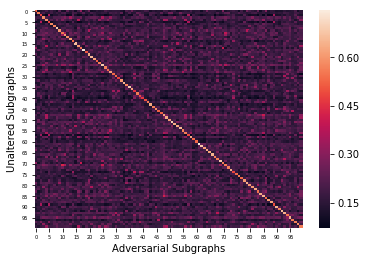

In [36]:
ax = sns.heatmap(adv_sim_mat, xticklabels=5, yticklabels=5)
plt.yticks(rotation=0)
plt.xticks(rotation=0)
plt.tick_params(axis='y',labelsize=5)
plt.tick_params(axis='x',labelsize=5)
plt.ylabel('Unaltered Subgraphs')
plt.xlabel('Adversarial Subgraphs')
plt.savefig('/home/tgebhart/projects/pt_activation/logdir/vis/ccff_mnist/adv_comb_heatmap.png', format='png', dpi=500)

In [37]:
moved_sim_mat = np.zeros((len(sample_graphs), len(moved_sample_graphs)))
for i in range(len(sample_graphs)):
    for j in range(len(moved_sample_graphs)):
#         moved_sim_mat[i,j] = 1 - lifetime_weighted_edge_distance(sample_graphs[i],moved_sample_graphs[j],lifetimes[i],moved_lifetimes[j])
        moved_sim_mat[i,j] = 1 - full_weighted_edge_distance(sample_graphs[i],moved_sample_graphs[j])

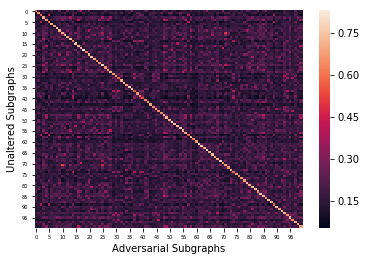

In [38]:
ax = sns.heatmap(moved_sim_mat, xticklabels=5, yticklabels=5)
plt.yticks(rotation=0)
plt.xticks(rotation=0)
plt.tick_params(axis='y',labelsize=5)
plt.tick_params(axis='x',labelsize=5)
plt.ylabel('Unaltered Subgraphs')
plt.xlabel('Adversarial Subgraphs')
plt.savefig('/home/tgebhart/projects/pt_activation/logdir/vis/ccff_mnist/moved_comb_heatmap.png', format='png', dpi=500)

In [39]:
# moved_dists = np.array([get_adv_dist(ims[i], moved_ims[i]) for i in range(res_df.shape[0])])

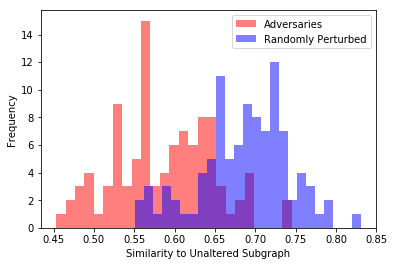

In [40]:
bins = 25
plt.hist(np.diagonal(adv_sim_mat), bins, alpha=0.5, label='Adversaries', color='r')
plt.hist(np.diagonal(moved_sim_mat), bins, alpha=0.5, label='Randomly Perturbed', color='b')
plt.xlabel('Similarity to Unaltered Subgraph')
plt.ylabel('Frequency')
plt.legend()

In [41]:
# bins = 25
# plt.hist(dists, bins, alpha=0.5, label='Adversaries', color='r')
# plt.hist(moved_dists, bins, alpha=0.5, label='Random Pertubation', color='b')
# plt.xlabel('Distance to Unaltered Image')
# plt.ylabel('Frequency')
# plt.legend()

Text(0.5, 0, 'Random Perturbation Similarity')

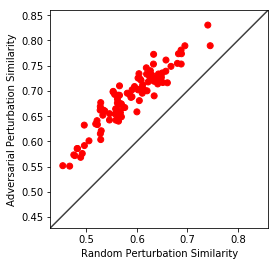

In [43]:
fig, ax = plt.subplots()
differs = np.diagonal(adv_sim_mat) - np.diagonal(moved_sim_mat)
colors = ['b' if differs[i] > 0 else 'r' for i in range(len(sample_graphs))]
ax.scatter(np.diagonal(adv_sim_mat), np.diagonal(moved_sim_mat), c=colors)
lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]

# now plot both limits against eachother
ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
ax.set_aspect('equal')
ax.set_xlim(lims)
ax.set_ylim(lims)
plt.ylabel('Adversarial Perturbation Similarity')
plt.xlabel('Random Perturbation Similarity')

In [46]:
differs[differs <= 0].shape[0]/len(sample_graphs)

1.0

In [47]:
def compute_num_generators(g):
    return len(g)
def compute_num_edges(g):
    num_edges = 0
    for sgk in g:
        num_edges += len(g[sgk].edges())
    return num_edges

In [48]:
num_generators = [compute_num_generators(g) for g in sample_graphs]
adv_num_generators = [compute_num_generators(g) for g in adv_sample_graphs]
moved_num_generators = [compute_num_generators(g) for g in moved_sample_graphs]

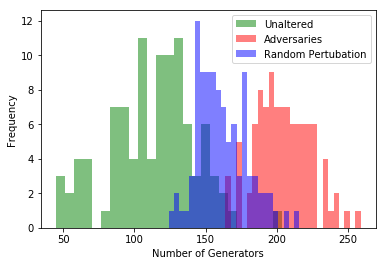

In [49]:
bins = 25
plt.hist(num_generators, bins, alpha=0.5, label='Unaltered', color='g')
plt.hist(adv_num_generators, bins, alpha=0.5, label='Adversaries', color='r')
plt.hist(moved_num_generators, bins, alpha=0.5, label='Random Pertubation', color='b')
plt.xlabel('Number of Generators')
plt.ylabel('Frequency')
plt.legend()

In [50]:
num_edges = [compute_num_edges(g) for g in sample_graphs]
adv_num_edges = [compute_num_edges(g) for g in adv_sample_graphs]
moved_num_edges = [compute_num_edges(g) for g in moved_sample_graphs]

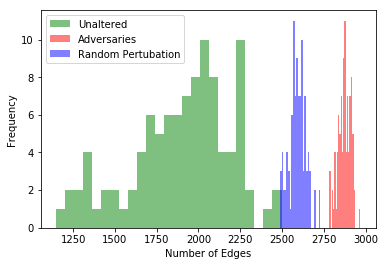

In [51]:
bins = 25
plt.hist(num_edges, bins, alpha=0.5, label='Unaltered', color='g')
plt.hist(adv_num_edges, bins, alpha=0.5, label='Adversaries', color='r')
plt.hist(moved_num_edges, bins, alpha=0.5, label='Random Pertubation', color='b')
plt.xlabel('Number of Edges')
plt.ylabel('Frequency')
plt.legend()

- Compute the set differences for each adversary and compare these set differences to each of the unaltered images like we did for the adv_sim_mat above. 
- Sort this similarity matrix by the _predicted_ class of the adversary. We would expect to see some sort of relationship emerge if these subgraphs were targeting class-specific information within the persistent subgraphs
- Compute these differences based on the composed graphs like in `lifetime_weighted_edge_distance()`

In [52]:
def set_difference(subgraphs1, subgraphs2):
    sg1keys = list(subgraphs1.keys())
    sg2keys = list(subgraphs2.keys())
    remove_edges = []
    edges2 = []
    for i in range(len(sg1keys)):
        g = subgraphs1[sg1keys[i]]
        remove_edges += list(g.edges)
    for i in range(len(sg2keys)):
        g = subgraphs2[sg2keys[i]]
        edges2 += list(g.edges)
    keep_edges = set(edges2).difference(set(remove_edges))
    ret_graph = nx.compose_all([subgraphs2[k] for k in sg2keys])
    rge = list(ret_graph.edges())
    ret_graph.remove_edges_from(e for e in rge if e not in keep_edges)
    return ret_graph

In [53]:
sorted_res_df = res_df.sort_values(by=['prediction'])
sorted_adv_df = adv_df.sort_values(by=['prediction'])

In [54]:
sorted_adv_df.head()

,class,loss,prediction
11,6,0.763623,0
33,4,0.763623,0
1,2,0.763623,1
35,2,0.763623,1
38,2,0.763623,1


In [55]:
adv_differences = [set_difference(sample_graphs[i], adv_sample_graphs[i]) for i in range(len(sample_graphs))]

combs = []
for i in range(len(sample_graphs)):
    combs.append(nx.compose_all([sample_graphs[i][k] for k in sample_graphs[i]]))

In [56]:
diff_sim_mat = np.zeros((len(combs),len(adv_differences)))
for i in range(len(combs)):
    g = combs[i]
    for j in range(len(adv_differences)):
        ag = adv_differences[j]
        diff_sim_mat[i,j] = 1 - weighted_edge_distance(g,ag)

In [57]:
sorted_diff_sim_mat = np.empty(diff_sim_mat.shape)
sidxs = list(sorted_adv_df.index)
# aidxs = list(sorted_adv_df.index)
aidxs = sidxs
for i in range(len(sidxs)):
    for j in range(len(aidxs)):
        sorted_diff_sim_mat[i,j] = diff_sim_mat[sidxs[i],aidxs[j]]
        
sdsmdf = pd.DataFrame(sorted_diff_sim_mat, columns=sorted_adv_df['prediction'], index=sorted_res_df['prediction'])

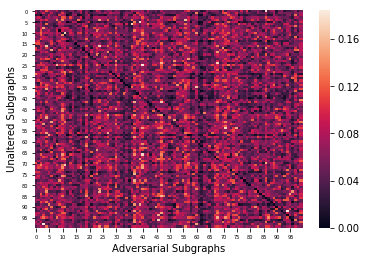

In [58]:
ax = sns.heatmap(diff_sim_mat, xticklabels=5, yticklabels=5)
plt.yticks(rotation=0)
plt.xticks(rotation=0)
plt.tick_params(axis='y',labelsize=5)
plt.tick_params(axis='x',labelsize=5)
plt.ylabel('Unaltered Subgraphs')
plt.xlabel('Adversarial Subgraphs')
plt.savefig('/home/tgebhart/projects/pt_activation/logdir/vis/ccff_mnist/adv_diff_heatmap.png', format='png', dpi=500)